In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns

import bayesflow as bf
import tensorflow as tf

from scipy.stats import halfnorm, maxwell

from functools import partial
from IPython.display import HTML
from bayesflow.simulation import Prior, Simulator, GenerativeModel

In [4]:
# Helper function for agent initialization
def initialize_agents(
        num_agents: int = 12,
        boundary_size: float = 10.0,
        rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    positions = rng.uniform(size=(num_agents, 2)) * boundary_size
    directions = rng.uniform(size=num_agents) * 2 * np.pi

    return positions, directions

In [5]:
# Simulator
def simulator_fun(
    theta: np.ndarray = None,
    num_agents: int = 12,
    num_timesteps: int = 100,
    boundary_size: float = 10.0,
    rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    if theta is not None:
        radius, speed, eta = theta[0], theta[1], theta[2]
    else:
        radius, speed, eta = 2.0, 1.0, 1.0

    trajectories = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))

    positions, directions = initialize_agents(num_agents, boundary_size, rng)
    trajectories[0] = positions
    headings[0] = directions[:, np.newaxis]

    for t in range(num_timesteps):
        new_directions = np.zeros(num_agents)
        for i in range(num_agents):
            neighbors = []
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius:
                    neighbors.append(directions[j])
            if neighbors:
                avg_direction = np.arctan2(np.mean(np.sin(neighbors)), np.mean(np.cos(neighbors)))
                new_directions[i] = avg_direction + rng.uniform(-eta * 0.5, eta * 0.5)
            else:
                new_directions[i] = directions[i]

        directions = new_directions
        
        # Update position upon new direction
        positions[:, 0] += speed * np.cos(directions)
        positions[:, 1] += speed * np.sin(directions)
        
        # Assumes periodic boundary condition
        positions = np.mod(positions, boundary_size)

        trajectories[t + 1] = positions
        headings[t + 1] = directions[:, np.newaxis]

    return np.concatenate((trajectories, headings), axis=-1, dtype=np.float32)

In [6]:
test = simulator_fun()
test

array([[[ 0.8264461 ,  8.181044  ,  5.949797  ],
        [ 8.192356  ,  3.2298748 ,  4.9176736 ],
        [ 1.4125601 ,  6.628247  ,  6.0778317 ],
        ...,
        [ 9.733518  ,  2.6115332 ,  0.4881305 ],
        [ 5.068994  ,  3.063797  ,  6.109974  ],
        [ 0.01421242,  4.9150276 ,  6.124465  ]],

       [[ 1.6470329 ,  7.609522  , -0.60835946],
        [ 9.191737  ,  3.1946888 , -0.0351934 ],
        [ 2.3622272 ,  6.3149858 , -0.3186253 ],
        ...,
        [ 9.614848  ,  1.6185995 , -1.6897464 ],
        [ 6.0540304 ,  2.8914502 ,  6.109974  ],
        [ 1.0016428 ,  4.756973  ,  6.124465  ]],

       [[ 2.5817862 ,  7.254225  , -0.36323205],
        [ 8.654129  ,  2.3514938 , -2.138394  ],
        [ 3.2939384 ,  5.951786  , -0.3716997 ],
        ...,
        [ 0.49364057,  1.1413954 , -0.49747044],
        [ 7.039067  ,  2.7191036 ,  6.109974  ],
        [ 1.9890732 ,  4.5989184 ,  6.124465  ]],

       ...,

       [[ 4.5820227 ,  0.9399048 , -1.278427  ],
        [ 5

In [7]:
# Helper function for animation
def animate(paths, boundary_size = 10.0):
    
    positions = paths[:,:,0:2]
    directions = paths[:,:,2:]
    
    fig, ax = plt.subplots(figsize=(4, 4))


    def update(frame):
        ax.clear()
        quiver = ax.quiver(positions[frame, :, 0], positions[frame, :, 1], np.cos(directions[frame]), np.sin(directions[frame]))
        quiver.set_offsets(positions[frame])
        quiver.set_UVC(np.cos(directions[frame]), np.sin(directions[frame]))
        ax.set_xlim(0, boundary_size)
        ax.set_ylim(0, boundary_size)
        return quiver,

    a = animation.FuncAnimation(fig, update, frames=len(positions), blit=True, repeat=False)
    plt.title("Vicsek Model")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    return a

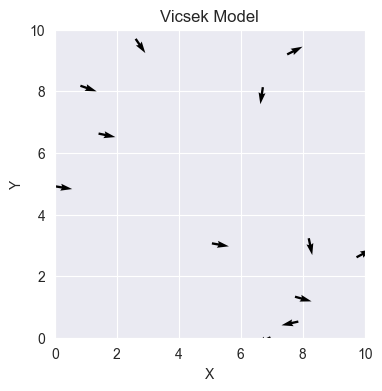

In [8]:
a0 = animate(test)

# Prior

In [9]:
param_names = [r'$r$', r'$v$', r'$\eta$']

In [10]:
def prior_fun(rng=None):
    
    if rng is None:
        rng = np.random.default_rng()
        
    r = maxwell.rvs(2.)
    v = maxwell.rvs(1.)
    eta = halfnorm.rvs(0., 1.)
    
    return np.array([r, v, eta], dtype=np.float32)

In [11]:
test_prior = [prior_fun() for _ in range(5)]
test_prior

[array([2.732011 , 1.8551807, 0.9420286], dtype=float32),
 array([3.0147142, 1.9702724, 0.6431865], dtype=float32),
 array([4.592371  , 2.0934234 , 0.41362542], dtype=float32),
 array([4.7899175 , 1.6404948 , 0.72351027], dtype=float32),
 array([2.504837 , 3.2875285, 1.2702874], dtype=float32)]

# Generative Model

In [12]:
prior = Prior(prior_fun=prior_fun)

In [13]:
simulator = Simulator(simulator_fun=simulator_fun)

In [14]:
model = GenerativeModel(prior=prior, simulator=simulator, simulator_is_batched=False, name="Vicsek V2")

INFO:root:Performing 2 pilot runs with the Vicsek V2 model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Prior Predictive Checks

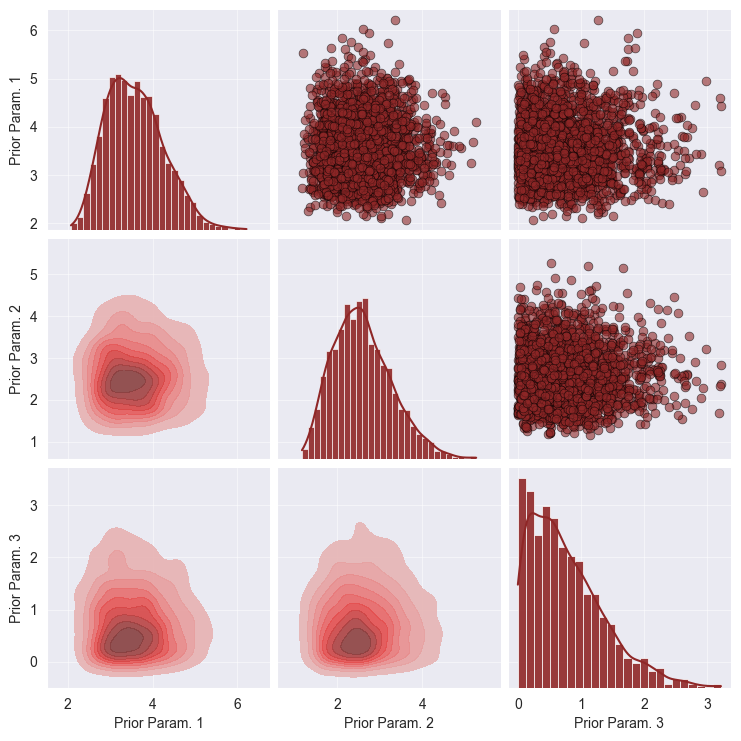

In [15]:
pp_check = prior.plot_prior2d()

# Prior Pushforward Checks

In [16]:
pushforward_sim = model(4)['sim_data']
pushforward_sim.shape

(4, 101, 12, 3)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


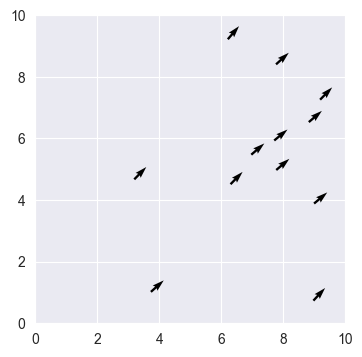

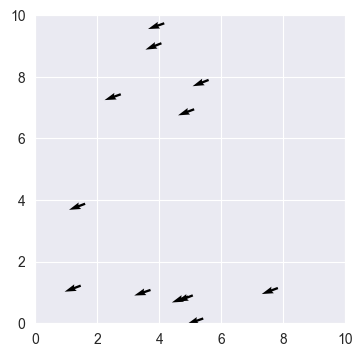

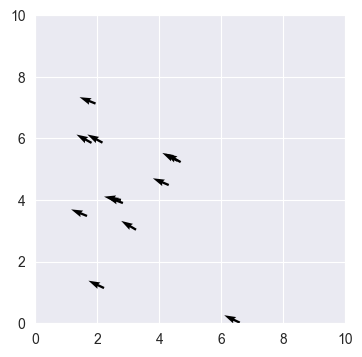

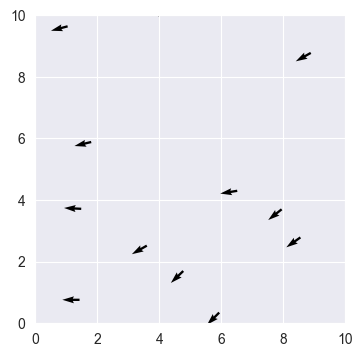

In [17]:
for i in range(pushforward_sim.shape[0]):
    a = animate(pushforward_sim[i])
    v = HTML(a.to_jshtml())

# Preprocessing Checks

In [18]:
preconfig_sim = model(100)

In [19]:
preconfig_sim['sim_data'].shape

(100, 101, 12, 3)

In [20]:

x = preconfig_sim['sim_data']
np.mean(x, axis=(0, 1, 2)), np.std(x, axis=(0, 1, 2))

(array([5.000765  , 4.9893875 , 0.00741038], dtype=float32),
 array([2.8906775, 2.8897307, 1.8183466], dtype=float32))

In [21]:
# This one takes into account global mean and std for simulation
x0 = (x[0] - np.mean(x, axis=(0, 1, 2))) / np.std(x, axis=(0, 1, 2))

In [22]:
x0.shape

(101, 12, 3)

In [23]:
x0[:,0]

array([[-5.96687555e-01,  1.01463914e+00,  3.37907672e+00],
       [ 4.16767210e-01,  1.29907727e+00,  1.46356508e-01],
       [ 1.25302768e+00,  6.59641087e-01, -3.62997860e-01],
       [-1.17010450e+00,  4.74922091e-01, -1.01056464e-01],
       [-3.19809496e-01, -1.45717531e-01, -3.50743949e-01],
       [ 6.75382853e-01, -4.88663703e-01, -1.86525628e-01],
       [ 5.66391349e-01, -1.53593731e+00, -9.24982488e-01],
       [ 1.61897397e+00, -1.53945482e+00, -5.91259776e-03],
       [-9.12381649e-01, -1.04262054e+00,  2.66168028e-01],
       [ 1.26636252e-01, -1.21115243e+00, -9.24802870e-02],
       [ 9.81922209e-01, -5.97413599e-01,  3.38144571e-01],
       [-1.43523824e+00, -4.50102389e-01,  7.31189474e-02],
       [ 1.29562283e+00, -1.21007419e+00, -1.28834200e+00],
       [-1.44621778e+00,  1.48010218e+00, -4.55421895e-01],
       [-5.94280958e-01,  8.61719787e-01, -3.49285960e-01],
       [ 4.32526857e-01,  6.30108416e-01, -1.26044005e-01],
       [ 1.45630705e+00,  3.85453999e-01

In [24]:
# This one takes into account variance for simulation
x1 = (x[0] - np.mean(x, axis=(0, 1))) / np.std(x, axis=(0, 1))

In [25]:
x1.shape

(101, 12, 3)

In [26]:
p = preconfig_sim['prior_draws']
p.shape

(100, 3)

In [27]:
p_mean = np.mean(p, axis=0)
p_std = np.std(p, axis=0)

p0 = (p - p_mean) / p_std
p0.shape

(100, 3)

# Configurator

In [28]:
def configurator(input_dict: dict = None, time_embedding: bool = False):
    output_dict = {}

    theta = input_dict['prior_draws']
    output_dict['parameters'] = theta

    x = input_dict['sim_data']
    
    # Standardizing the data
    x_mean = np.mean(x, axis=(0, 1, 2))
    x_std = np.std(x, axis=(0, 1, 2))
    # 
    x = (x - x_mean) / x_std
    # x = (x - x.min()) / (x.max() - x.min())
    #x = np.subtract(x, x.min(axis=0)) / np.subtract(x.max(axis=0), x.min(axis=0))
    
    # Standardizing the prior draws
    params = input_dict['prior_draws']
    params_mean = np.mean(params, axis=0)
    params_std = np.std(params, axis=0)
    # 
    params = (params - params_mean) / params_std
    #params = (params - params.min()) / (params.max() - params.min())
    #params = np.subtract(params, params.min(axis=0)) / np.subtract(params.max(axis=0), params.min(axis=0))
    
    # add time encoding to the data x
    if time_embedding:
        batch_size, num_timesteps, num_agents, _ = x.shape
        time_encoding = np.linspace(0, 1, num_timesteps)
        time_encoding_batched = np.tile(
            time_encoding[np.newaxis, :, np.newaxis, np.newaxis], 
            (batch_size, 1, num_agents, 1)
        )
        
    x1 = np.swapaxes(x, 2, 1)
    

    output_dict['summary_conditions'] = x1.astype(np.float32)
    output_dict['parameters'] = params.astype(np.float32)
    
    return output_dict

In [29]:
test_sim = model(100)
test_sim['sim_data'].shape

(100, 101, 12, 3)

In [30]:
test_config = configurator(test_sim)
test_config['summary_conditions'][0].astype(float)
test_config['summary_conditions'].max()

3.1785266

In [31]:
test_config['parameters'].max()

3.0079713

# Neural Approximator

In [33]:
# As advised, use SetTransformer in place of DeepSet
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.GRU(units=128)),
    bf.networks.SetTransformer(input_dim=128, summary_dim=64)
])

In [34]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=6,
    coupling_settings={
        'kernel_regularizer': tf.keras.regularizers.l2(1e-4),
        'dropout_prob': 0.10
    }
)

In [35]:
amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)

In [36]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [37]:
amortizer.summary()

Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  605292    
 ibleNetwork)                                                    
                                                                 
 hierarchical_network_1 (Hi  multiple                  468736    
 erarchicalNetwork)                                              
                                                                 
Total params: 1074028 (4.10 MB)
Trainable params: 1073992 (4.10 MB)
Non-trainable params: 36 (144.00 Byte)
_________________________________________________________________


# Mini-Training

In [39]:
mini_sims = model(2500)

In [40]:
mini_history = trainer.train_offline(mini_sims, epochs=100, batch_size=500, validation_sims=model(100))

Training epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 4.258


Training epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 4.258


Training epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 4.256


Training epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 4.254


Training epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 4.248


Training epoch 6:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 4.232


Training epoch 7:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 4.231


Training epoch 8:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 4.240


Training epoch 9:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 4.192


Training epoch 10:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 4.231


Training epoch 11:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 4.209


Training epoch 12:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 4.225


Training epoch 13:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 4.135


Training epoch 14:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 4.201


Training epoch 15:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 4.212


Training epoch 16:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 4.183


Training epoch 17:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 4.257


Training epoch 18:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 4.196


Training epoch 19:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 4.262


Training epoch 20:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 4.174


Training epoch 21:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 4.249


Training epoch 22:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 4.123


Training epoch 23:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 4.470


Training epoch 24:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 4.140


Training epoch 25:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 4.261


Training epoch 26:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 4.136


Training epoch 27:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 4.105


Training epoch 28:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 4.136


Training epoch 29:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 4.092


Training epoch 30:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 4.098


Training epoch 31:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 3.985


Training epoch 32:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 3.891


Training epoch 33:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 4.005


Training epoch 34:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 4.156


Training epoch 35:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 3.858


Training epoch 36:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 3.869


Training epoch 37:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 3.955


Training epoch 38:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 3.843


Training epoch 39:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 3.716


Training epoch 40:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 3.773


Training epoch 41:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 3.547


Training epoch 42:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 3.979


Training epoch 43:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 3.543


Training epoch 44:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 3.606


Training epoch 45:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 3.414


Training epoch 46:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 3.419


Training epoch 47:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 3.377


Training epoch 48:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 3.417


Training epoch 49:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 3.424


Training epoch 50:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 3.661


Training epoch 51:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: 3.392


Training epoch 52:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 3.113


Training epoch 53:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: 3.214


Training epoch 54:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 3.194


Training epoch 55:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: 3.044


Training epoch 56:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 3.105


Training epoch 57:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 3.169


Training epoch 58:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 3.281


Training epoch 59:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 2.997


Training epoch 60:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 3.195


Training epoch 61:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 2.914


Training epoch 62:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: 2.993


Training epoch 63:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 3.011


Training epoch 64:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 2.858


Training epoch 65:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 2.882


Training epoch 66:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: 2.933


Training epoch 67:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: 2.910


Training epoch 68:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: 2.865


Training epoch 69:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: 2.908


Training epoch 70:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 2.804


Training epoch 71:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 2.761


Training epoch 72:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 2.887


Training epoch 73:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 2.766


Training epoch 74:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 2.752


Training epoch 75:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 2.756


Training epoch 76:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: 2.732


Training epoch 77:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: 2.756


Training epoch 78:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 2.725


Training epoch 79:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 2.749


Training epoch 80:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 2.677


Training epoch 81:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: 2.732


Training epoch 82:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: 2.709


Training epoch 83:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 2.688


Training epoch 84:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: 2.825


Training epoch 85:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: 2.788


Training epoch 86:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 2.699


Training epoch 87:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 2.666


Training epoch 88:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: 2.638


Training epoch 89:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 2.646


Training epoch 90:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 2.682


Training epoch 91:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: 2.692


Training epoch 92:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: 2.680


Training epoch 93:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 2.681


Training epoch 94:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 2.685


Training epoch 95:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 2.689


Training epoch 96:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 2.681


Training epoch 97:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: 2.672


Training epoch 98:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 2.668


Training epoch 99:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 2.667


Training epoch 100:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 2.667


# Training

In [41]:
# Generate simulation data for training
training_sims = model(25000)

In [42]:
history = trainer.train_offline(training_sims, epochs=100, batch_size=1000, validation_sims=model(200))

Training epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 2.809


Training epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 2.858


Training epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 2.583


Training epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 2.497


Training epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 2.870


Training epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 2.941


Training epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 2.847


Training epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 2.310


Training epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 3.834


Training epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 2.554


Training epoch 11:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 4.685


Training epoch 12:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 2.589


Training epoch 13:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 2.428


Training epoch 14:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 2.413


Training epoch 15:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 2.503


Training epoch 16:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 2.890


Training epoch 17:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 1.951


Training epoch 18:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 2.551


Training epoch 19:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 2.849


Training epoch 20:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 2.636


Training epoch 21:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 2.057


Training epoch 22:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 2.663


Training epoch 23:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 3.081


Training epoch 24:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 2.808


Training epoch 25:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 2.328


Training epoch 26:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 2.274


Training epoch 27:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 2.125


Training epoch 28:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 2.059


Training epoch 29:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 1.934


Training epoch 30:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 1.990


Training epoch 31:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 1.893


Training epoch 32:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 2.699


Training epoch 33:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 2.095


Training epoch 34:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 2.420


Training epoch 35:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 1.757


Training epoch 36:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 2.365


Training epoch 37:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 2.671


Training epoch 38:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 1.906


Training epoch 39:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 1.923


Training epoch 40:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 1.747


Training epoch 41:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 1.492


Training epoch 42:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 1.511


Training epoch 43:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 1.714


Training epoch 44:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 2.228


Training epoch 45:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 1.732


Training epoch 46:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 2.118


Training epoch 47:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 4.070


Training epoch 48:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 2.196


Training epoch 49:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 1.304


Training epoch 50:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 1.839


Training epoch 51:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: 2.365


Training epoch 52:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 2.365


Training epoch 53:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: 2.594


Training epoch 54:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 1.194


Training epoch 55:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: 2.041


Training epoch 56:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 1.799


Training epoch 57:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 1.700


Training epoch 58:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 1.202


Training epoch 59:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 1.669


Training epoch 60:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 1.931


Training epoch 61:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 2.580


Training epoch 62:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: 1.652


Training epoch 63:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 1.488


Training epoch 64:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 1.347


Training epoch 65:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 2.069


Training epoch 66:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: 2.198


Training epoch 67:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: 2.740


Training epoch 68:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: 2.721


Training epoch 69:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: 1.193


Training epoch 70:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 2.543


Training epoch 71:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 2.657


Training epoch 72:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 2.000


Training epoch 73:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 1.694


Training epoch 74:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 1.112


Training epoch 75:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 1.829


Training epoch 76:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: 1.981


Training epoch 77:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: 1.619


Training epoch 78:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 2.071


Training epoch 79:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 1.635


Training epoch 80:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 1.533


Training epoch 81:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: 1.291


Training epoch 82:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: 2.364


Training epoch 83:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 1.933


Training epoch 84:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: 1.612


Training epoch 85:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: 1.629


Training epoch 86:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 2.168


Training epoch 87:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 2.808


Training epoch 88:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: 2.330


Training epoch 89:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 1.935


Training epoch 90:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 3.307


Training epoch 91:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: 2.131


Training epoch 92:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: 2.521


Training epoch 93:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 2.146


Training epoch 94:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 2.237


Training epoch 95:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 2.483


Training epoch 96:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 2.256


Training epoch 97:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: 2.285


Training epoch 98:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 2.240


Training epoch 99:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 2.218


Training epoch 100:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 2.221


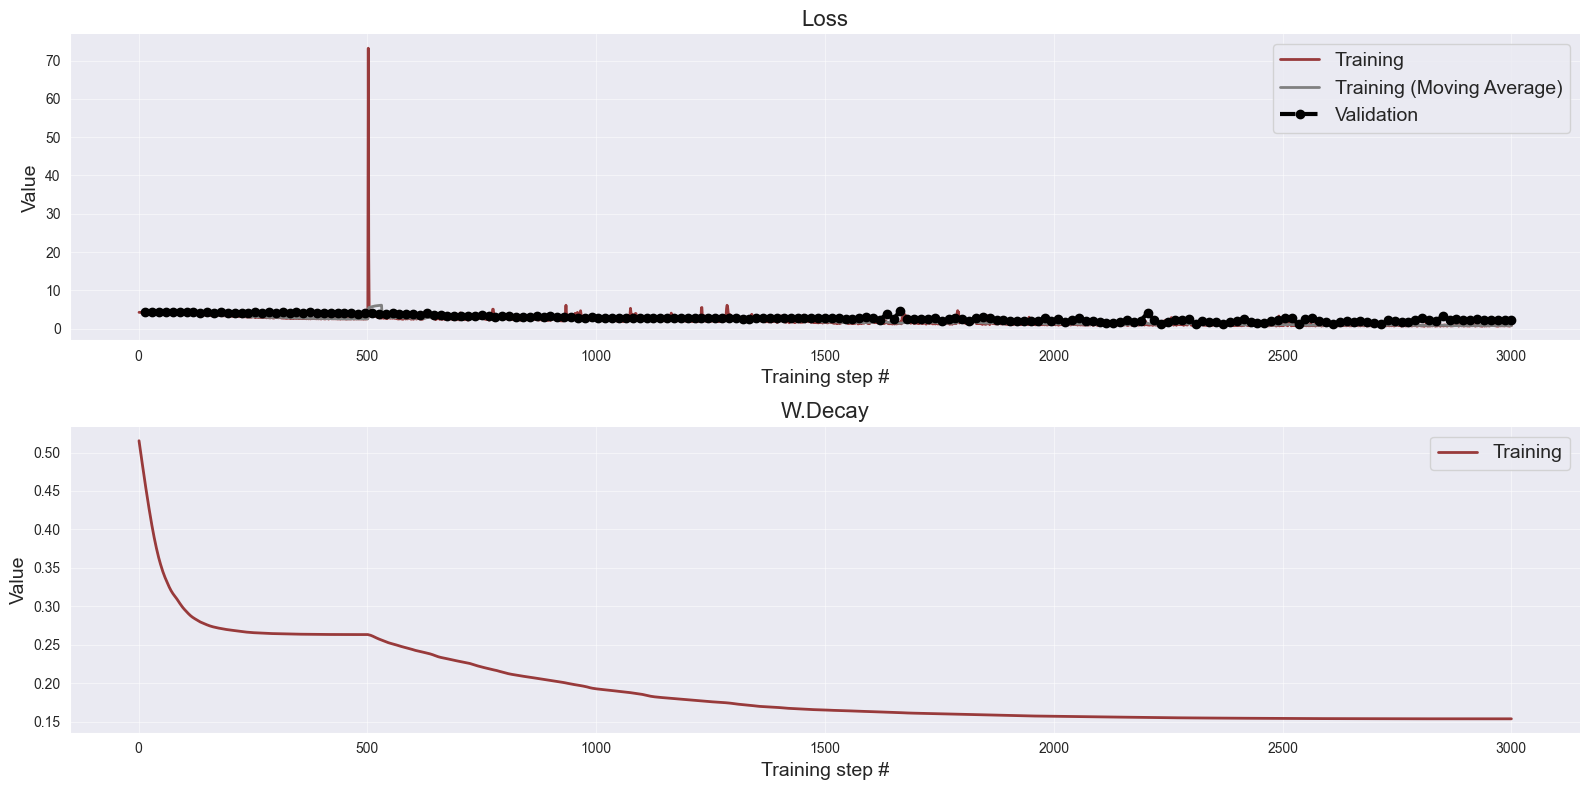

In [43]:
f = bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'], moving_average=True)

# Validation

In [44]:
validation_sim = model(2500)

In [45]:
validation_sim['sim_data']

array([[[[ 5.0736670e+00,  5.7767324e+00,  4.7276416e+00],
         [ 3.9296346e+00,  2.0902870e+00,  3.6150444e-01],
         [ 5.2313886e+00,  5.3665624e+00,  3.5200613e+00],
         ...,
         [ 2.4401546e+00,  7.1848602e+00,  8.5502487e-01],
         [ 8.4385529e+00,  4.8579559e+00,  3.8132079e+00],
         [ 6.6900482e+00,  7.1981177e+00,  6.3196623e-01]],

        [[ 7.3862534e+00,  4.6462593e+00, -4.5467582e-01],
         [ 5.4258590e+00,  9.9956894e+00, -9.5052034e-01],
         [ 7.1597838e+00,  3.6614766e+00, -7.2401643e-01],
         ...,
         [ 3.6288848e+00,  4.9016728e+00, -1.0907694e+00],
         [ 6.3190789e+00,  3.3971841e+00, -2.5381422e+00],
         [ 4.7364206e+00,  5.5220017e+00, -2.4325011e+00]],

        [[ 6.0590658e+00,  2.4406757e+00, -2.1124940e+00],
         [ 7.6551175e+00,  1.2827146e+00,  5.2358598e-01],
         [ 6.2946625e+00,  1.2371025e+00, -1.9135544e+00],
         ...,
         [ 3.3503110e+00,  2.3426845e+00, -1.6792303e+00],
         [

In [46]:
validation_configured = configurator(validation_sim)

In [47]:
validation_configured['summary_conditions']

array([[[[ 0.02533246,  0.27078328,  2.506927  ],
         [ 0.8276267 , -0.12149153, -0.28296354],
         [ 0.36719203, -0.8868303 , -1.1754467 ],
         ...,
         [ 0.553182  , -0.43321005, -1.1022749 ],
         [ 0.2695153 , -1.2801657 , -1.0578449 ],
         [-0.07576993,  1.3660911 , -1.0975457 ]],

        [[-0.3715611 , -1.0084153 ,  0.15642552],
         [ 0.14751668,  1.7347637 , -0.5499005 ],
         [ 0.92090243, -1.2886434 ,  0.2436818 ],
         ...,
         [-1.3569522 , -0.18542534, -0.66075975],
         [-0.99742496, -1.0030558 , -0.66075975],
         [-1.2299603 ,  1.6045464 , -1.0256406 ]],

        [[ 0.08005002,  0.12845403,  1.8568286 ],
         [ 0.7490587 , -0.4632117 , -0.42796254],
         [ 0.44892642, -1.3044708 , -1.068348  ],
         ...,
         [-1.4842539 , -1.2201865 , -1.0201385 ],
         [-1.707965  ,  1.3850839 , -1.0201385 ],
         [ 1.5375749 ,  0.5203484 , -1.0201385 ]],

        ...,

        [[-0.8882991 ,  0.7594044 ,  0

In [48]:
post_samples = amortizer.sample(validation_configured, n_samples=100)
post_samples

array([[[ 0.3306778 , -0.02707705, -0.6806441 ],
        [ 0.68166655, -0.05195488, -0.6055905 ],
        [-0.69617116,  0.06951196, -0.15626891],
        ...,
        [ 1.64605   ,  0.01144707, -0.1715428 ],
        [ 0.15768152,  0.06042905, -0.02183954],
        [-0.2440658 , -0.05276613, -0.82455355]],

       [[-0.04564417,  0.660279  ,  0.7088658 ],
        [-1.2826933 ,  0.5106121 , -0.02248582],
        [ 0.16670497,  0.5432363 ,  0.7331795 ],
        ...,
        [-1.4738812 ,  0.59856576,  0.76119983],
        [-0.3305268 ,  0.6370375 ,  1.069395  ],
        [-0.86544436,  0.5530895 ,  0.2904992 ]],

       [[ 1.7797644 , -1.373113  , -0.10837558],
        [-0.7022236 , -1.33208   , -1.0908564 ],
        [ 0.34323427, -1.3077936 , -0.32455963],
        ...,
        [-0.8500418 , -1.4238441 , -0.79907876],
        [-1.412417  , -1.3724827 , -0.22356848],
        [ 1.9792262 , -1.3288244 , -0.785612  ]],

       ...,

       [[ 2.077228  , -0.27084297, -0.8151482 ],
        [-0

In [49]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=2500)
prior_means, prior_stds

(array([[3.576329  , 2.5967402 , 0.80644333]], dtype=float32),
 array([[0.6545303, 0.6792337, 0.6102345]], dtype=float32))

In [50]:
prior_samples = validation_configured['parameters']
prior_samples

array([[-1.4601066 , -0.00252903, -0.30931032],
       [ 0.1586102 ,  0.6845875 ,  1.0256373 ],
       [-0.8579011 , -1.3892627 , -1.1172084 ],
       ...,
       [ 1.3644172 , -0.1443466 , -0.5169204 ],
       [-1.1771421 ,  0.64294744,  0.8166477 ],
       [-0.22585331, -0.79369324, -0.10292102]], dtype=float32)

In [51]:
prior_samples_unnormed = prior_samples * prior_stds + prior_means

# Parameter Recovery

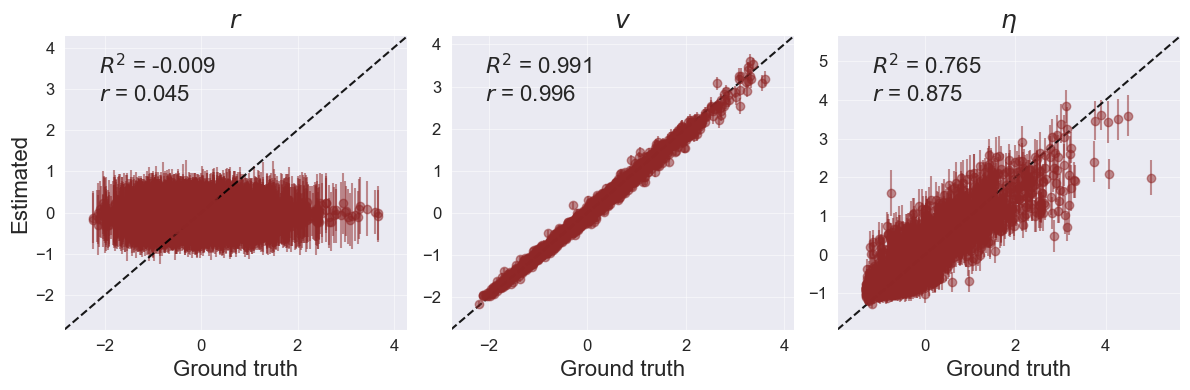

In [52]:
g = bf.diagnostics.plot_recovery(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

The drift $v$ shows near-perfect recovery, followed by the noise parameter $\eta$.

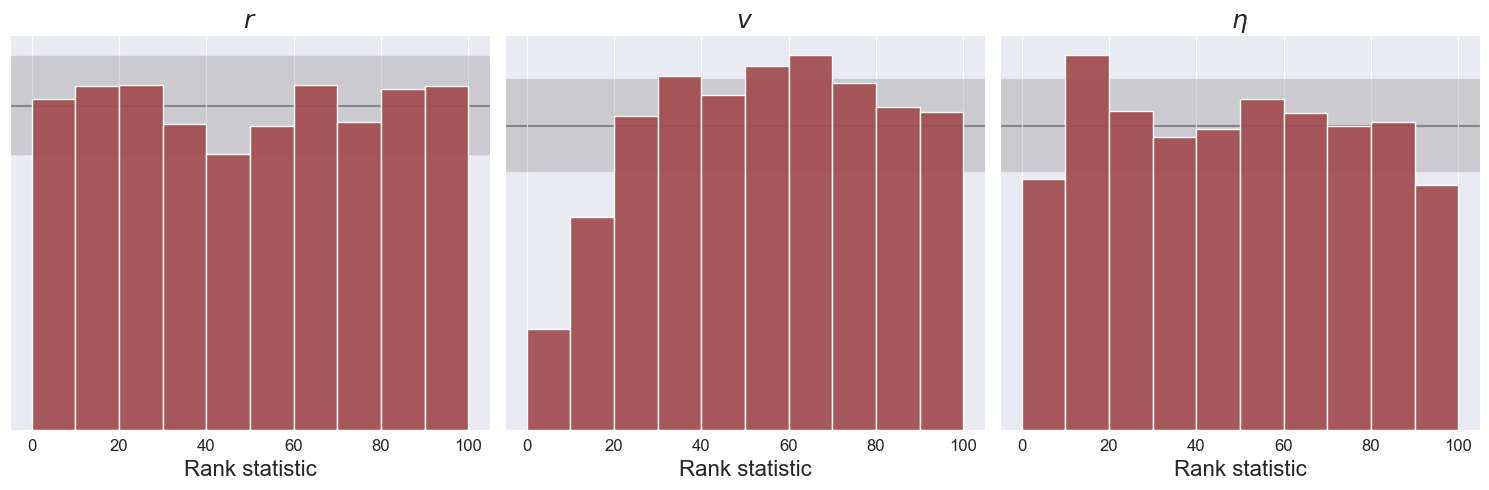

In [53]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10)

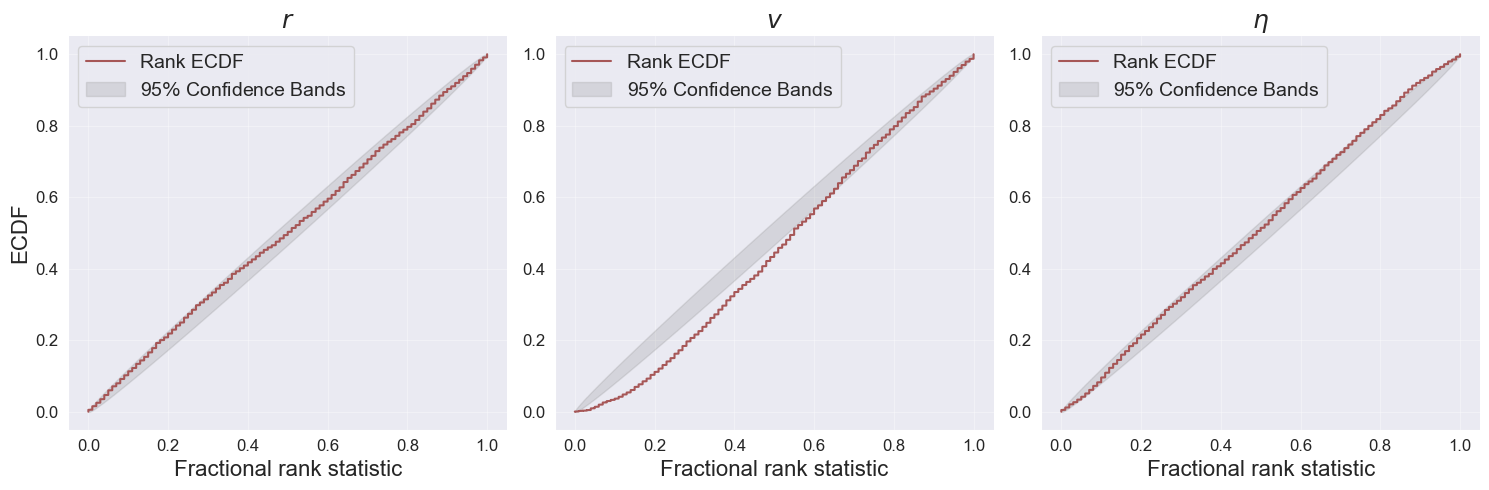

In [54]:
e = bf.diagnostics.plot_sbc_ecdf(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

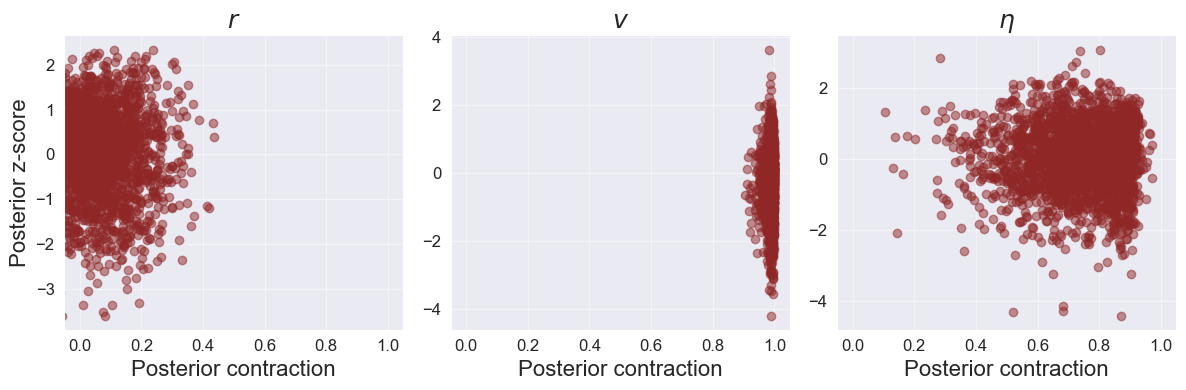

In [55]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

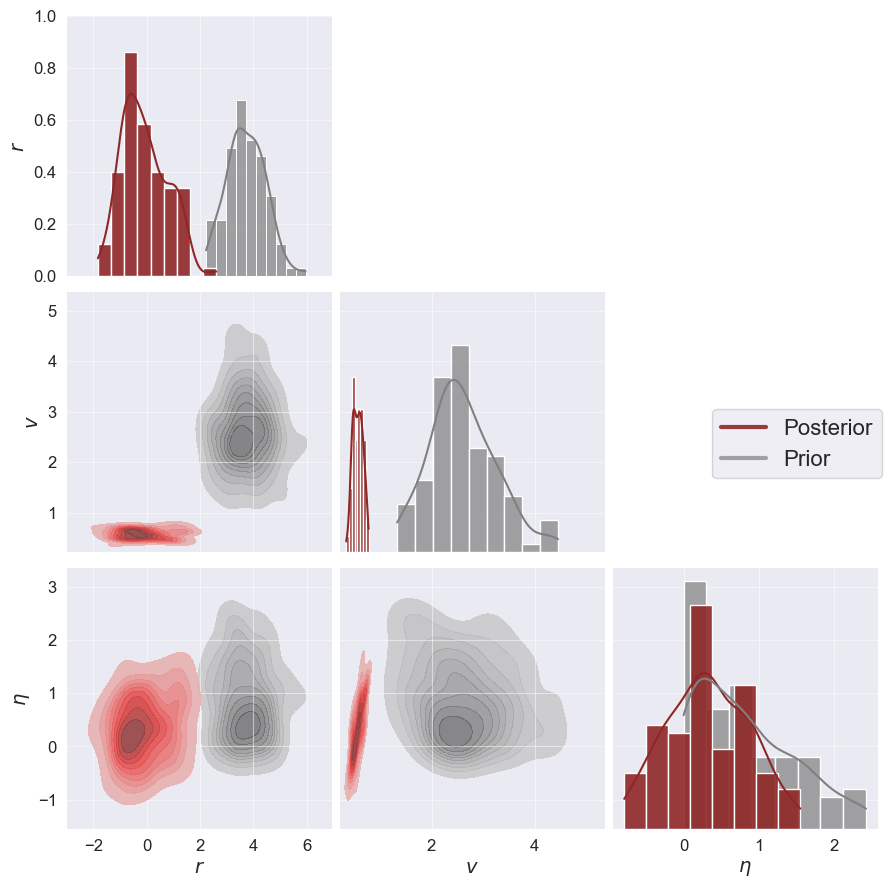

In [56]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[1], prior=prior, param_names=param_names)